In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
%matplotlib inline
np.set_printoptions(suppress=True)
%load_ext autoreload

## acquire 20newsgroups dataset

In [2]:
categories = None  # ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

### preprocess data and get document_term_matrix

In [3]:
TOKEN_PAT = r'\b[^(\W|\d|_)]{1,}\w\w+\b'
cnt_vecr = CountVectorizer(stop_words='english', min_df=0.005, max_df=0.2, token_pattern=TOKEN_PAT)
dtm = cnt_vecr.fit_transform(newsgroups_train.data)
print('{} documents'.format(dtm.shape[0]))

good_ics = np.where((dtm > 0).sum(axis=1) > 10)[0]
good_newsgroup_data = [newsgroups_train.data[i] for i in good_ics]  # no pointless docs in training
dtm = cnt_vecr.fit_transform(good_newsgroup_data)
dtm[dtm > 10] = 10  # no pointless word counts
print('{} useful documents'.format(dtm.shape[0]))

vectors_tfidf = TfidfTransformer().fit_transform(dtm)
vocab = cnt_vecr.get_feature_names()
P_term = dtm.sum(axis=0) / dtm.sum()
print('{} terms in vocab'.format(len(vocab)))

11314 documents
8436 useful documents
2761 terms in vocab


## anchor word topic model

In [4]:
%autoreload
from topmodel import TopModel, show_topics

In [5]:
tm = TopModel(n_topics=20, seed=100)
%time tm.fit(dtm)
print('computing A took {} iterations'.format(tm.n_iter_fit))

CPU times: user 15.9 s, sys: 15.6 s, total: 31.5 s
Wall time: 9.8 s
computing A took 40 iterations


In [6]:
for i, t in enumerate(show_topics(tm.topic_term_matrix, vocab, P_term, lbd=0.8, n_top_terms=15)):
    print('{:3d}: {}'.format(i, t))

  0: geb dsl n3jxp chastity shameful cadre intellect skepticism pitt surrender gordon banks soon patient patients
  1: mouse button desktop ball keyboard diamond driver modem pins ports gateway sys annoying port bat
  2: belief kent atheists believing gods punishment islam cheers god heaven atheism christians scripture sin bobby
  3: zip pub indiana ftp shareware directory gif routine updated helps site bbs files desktop latest
  4: scsi ide controller quadra drives isa vlb drive bus boot pins quantum motherboard cpu simms
  5: motif x11r5 widget core xlib greatly compile classes appreciated warning hello replies implement marc libraries
  6: ground wire tank rear dod neutral ride amp bike connected bikes signals voltage circuit seat
  7: toronto rangers leafs islanders playoff detroit pitching wings quebec playoffs fans montreal nhl pittsburgh van
  8: object planet energy dictionary thanx appreciated industrial observations pictures surface signature greatly describes schools strengt

In [7]:
for i, a in enumerate(tm.anchors):
    print(i, vocab[a])

0 banks
1 mouse
2 belief
3 pub
4 scsi
5 motif
6 ground
7 toronto
8 object
9 food
10 picture
11 brand
12 israel
13 vga
14 print
15 window
16 values
17 comp
18 keys
19 nasa


### recover topic x document matrix W
it makes sense to `normalize(W, axis=0, norm='l1')`

In [8]:
# product matrix M.T is document term matrix
#      A.T
# W.T  M.T
%time doc_topic_mat = tm.transform(dtm)
doc_topic_mat = normalize(doc_topic_mat, axis=0, norm='l1')

print('computing W took {} iterations'.format(tm.n_iter_transform))

CPU times: user 3.02 s, sys: 3.38 s, total: 6.4 s
Wall time: 5.26 s
computing W took 40 iterations


### sparseness

In [9]:
import pandas as pd
pd.DataFrame(tm.topic_term_matrix.T).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03
mean,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04
std,2.100858e-03,1.106427e-03,7.070802e-04,1.099415e-03,9.506737e-04,9.384922e-04,5.336129e-04,7.106747e-04,6.908542e-04,5.487372e-04,6.115572e-04,8.027886e-04,5.395227e-04,1.171970e-03,7.256360e-04,1.052258e-03,6.572616e-04,6.981365e-04,6.418793e-04,5.812954e-04
min,7.145969e-20,4.563118e-22,4.984865e-20,5.780792e-25,1.490955e-25,8.542993e-23,3.124755e-23,6.647387e-23,6.640976e-22,3.062645e-18,3.181285e-21,5.558001e-24,1.244627e-20,2.981140e-25,4.389323e-23,6.059913e-24,3.706199e-22,7.547301e-23,1.511216e-23,2.481462e-23
25%,2.378639e-08,4.906750e-06,5.483150e-05,7.208777e-06,6.480969e-06,1.190698e-05,9.031291e-05,5.396581e-05,5.014564e-05,9.843531e-05,6.710853e-05,3.566799e-05,8.503959e-05,6.584256e-07,3.730488e-05,1.009183e-05,5.329325e-05,3.975047e-05,8.091485e-05,7.937822e-05
50%,3.679883e-06,6.380681e-05,1.589087e-04,6.837958e-05,7.671710e-05,9.135802e-05,1.929928e-04,1.401070e-04,1.576776e-04,1.948083e-04,1.704832e-04,1.275279e-04,1.969143e-04,2.872495e-05,1.404171e-04,8.702317e-05,1.634282e-04,1.421808e-04,1.791463e-04,1.812845e-04
75%,1.423114e-04,2.842142e-04,3.826815e-04,2.948408e-04,3.258263e-04,3.094222e-04,4.215212e-04,3.664839e-04,4.001093e-04,3.942396e-04,3.980819e-04,3.418445e-04,4.235525e-04,2.448516e-04,3.738076e-04,3.197336e-04,3.838080e-04,3.806361e-04,3.866401e-04,4.052255e-04
max,3.659952e-02,3.516804e-02,1.825182e-02,2.014753e-02,2.092784e-02,2.208462e-02,6.770503e-03,1.070800e-02,1.585033e-02,7.339971e-03,9.797311e-03,1.347666e-02,8.517583e-03,2.746152e-02,1.261169e-02,3.037407e-02,1.197262e-02,9.355435e-03,1.312521e-02,9.984839e-03


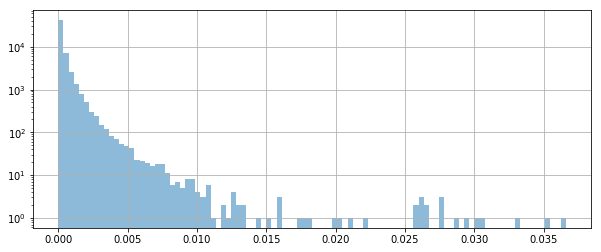

In [10]:
pd.Series(tm.topic_term_matrix.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))

In [11]:
pd.DataFrame(doc_topic_mat).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03
mean,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04,1.185396e-04
std,7.463469e-04,5.796645e-04,5.541268e-04,1.105254e-03,7.506698e-04,1.120845e-03,8.337902e-04,7.183061e-04,6.852961e-04,7.330796e-04,5.407220e-04,4.168859e-04,5.616326e-04,6.779788e-04,7.152648e-04,8.651254e-04,6.226724e-04,8.922374e-04,7.283977e-04,8.371058e-04
min,4.341914e-114,5.112908e-82,1.231760e-101,7.787188e-63,4.294770e-100,9.537649e-103,1.495672e-96,9.598625e-88,5.267394e-84,2.305850e-101,1.832886e-85,7.087677e-78,4.096580e-99,1.487145e-92,1.699635e-91,1.605355e-86,2.290698e-99,3.580533e-76,9.093670e-101,8.993310e-85
25%,5.777650e-24,4.797919e-16,1.209912e-15,2.984163e-18,2.266059e-16,6.087196e-16,1.727266e-13,4.288858e-15,2.020276e-13,6.145367e-13,5.484975e-12,1.720771e-14,1.812968e-15,3.340347e-19,3.852074e-13,5.400397e-16,1.435619e-13,2.154186e-14,9.334260e-14,7.084888e-14
50%,2.948865e-17,2.149056e-11,5.027433e-10,4.984748e-13,9.155677e-12,5.097738e-11,3.648935e-09,1.468578e-10,1.795551e-09,2.059425e-08,9.603306e-09,3.756442e-10,2.803331e-10,2.465730e-13,1.438310e-09,3.830600e-11,2.877162e-09,2.294495e-10,9.667448e-10,7.469382e-10
75%,2.026163e-11,2.401356e-07,7.036249e-06,7.561083e-08,2.897710e-07,6.401994e-07,6.428348e-06,2.554326e-06,2.400183e-06,1.691495e-05,3.841949e-06,3.432826e-06,3.321016e-06,3.718994e-08,7.541613e-07,5.846938e-07,6.079323e-06,1.214961e-06,1.838299e-06,1.493320e-06
max,1.558651e-02,1.861496e-02,2.024308e-02,4.684905e-02,3.541387e-02,4.221822e-02,5.981672e-02,4.585549e-02,2.520013e-02,3.231703e-02,2.327587e-02,1.094480e-02,1.547980e-02,3.451661e-02,2.537488e-02,3.806671e-02,1.874916e-02,3.224264e-02,1.912307e-02,2.733240e-02


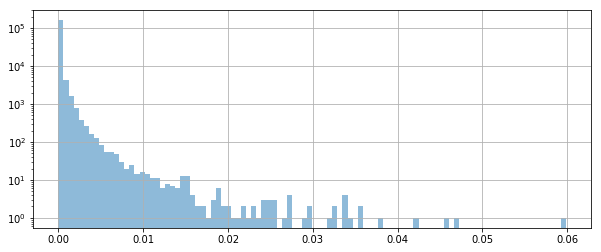

In [12]:
pd.Series(doc_topic_mat.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))

## sklearn NMF

In [13]:
m,n=vectors_tfidf.shape
d=20  # num topics

# beta_loss: 1 = kullback-leibler, 2 = frobenius-norm
clf = decomposition.NMF(n_components=d, random_state=1, solver='mu', beta_loss=2)

%time W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

CPU times: user 2.58 s, sys: 3.99 s, total: 6.56 s
Wall time: 1.72 s


In [14]:
for i, t in enumerate(show_topics(H1, vocab, P_term, lbd=0.8, n_top_terms=15)):
    print('{:3d}: {}'.format(i, t))

  0: say believe bible christian christians things church faith evidence christianity religion time truth really point
  1: program software files image mac screen graphics printer use file memory using ftp format postscript
  2: year season games boston pittsburgh chicago montreal pitching rangers toronto quebec louis detroit hit atlanta
  3: dsl n3jxp chastity geb cadre shameful intellect skepticism pitt surrender gordon banks soon edu patient
  4: key chip clipper encryption keys escrow nsa encrypted algorithm crypto secure phones des wiretap secret
  5: drive scsi drives ide controller floppy disk hard boot quantum motherboard meg bios external internal
  6: game team players hockey nhl player teams baseball play leafs scored games coach fans score
  7: mail edu send address list email mailing fax university interested internet australia phone info bitnet
  8: armenian armenians turkish armenia turkey turks genocide argic serdar muslim soviet russian republic greek massacre
  9: ca